# NLP EXPERIMENTS AND FIGURES

## DESCRIPTION
The objective of this analysis was to study possible insights about performing n-year cancer survival prediction using unstructured medical text notes. We explore the convenience to use clinical text to show that even applying simple feature transformations to the text like term-frequency inverse document-frequency (TF-IDF), it can be a most accurate way to predict survival than classical stage/grade used in the clinic. It is out of the scope of this study to apply the state of the art for NLP text classification problems. We selected patients with breast, glioma, lung and prostate cancer. Each cancer type was treated as a separate study but followed the same methodology.

## STATEMENT
 This file is part of <https://github.com/medomics>, a package providing 
 research utility tools for developing precision medicine applications.
 
 --> Copyright (C) 2020  MEDomics consortium

     This package is free software: you can redistribute it and/or modify
     it under the terms of the GNU General Public License as published by
     the Free Software Foundation, either version 3 of the License, or
     (at your option) any later version.

     This package is distributed in the hope that it will be useful,
     but WITHOUT ANY WARRANTY; without even the implied warranty of
     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
     GNU General Public License for more details.
 
     You should have received a copy of the GNU General Public License
     along with this package.  If not, see <http://www.gnu.org/licenses/>.

## IMPORTS

In [1]:
import re
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')

## DEFINE PLOTS

In [2]:
# import pandas as pd
# unpickled_df = pd.read_pickle("/home/linh/nlp/ClinicalBERT_Notebook/Plots/DEID_EXP_FILES/glioma30_deid_old.pickle")  
# unpickled_df

In [3]:
# unpickled_df[0].keys()

In [4]:
import pandas as pd
path = '/home/linh/nlp/ClinicalBERT_Notebook/BERToutputs/'
f1_bert_results = pd.read_csv(path+'f1_plot.csv')
f1_bert_results

,days,mean,std
0,30,0.715,0.039
1,60,0.764,0.028
2,120,0.762,0.028
3,180,0.779,0.035
4,240,0.786,0.028
5,300,0.799,0.038
6,365,0.814,0.030


In [5]:
path_auc = '/home/linh/nlp/ClinicalBERT_Notebook/BERToutputs/'
auc_bert_results = pd.read_csv(path+'auc_plot.csv')
auc_bert_results

,days,mean,std
0,30,0.619,0.048
1,60,0.680,0.042
2,120,0.699,0.040
3,180,0.726,0.040
4,240,0.749,0.042
5,300,0.801,0.047
6,365,0.834,0.039


In [29]:
def plot_test(results, disease, period_of_analysis_days=None):
    """This funtion plot the experiment results."""
    disease_name = ''
    if disease[0] == 'g':
        disease_name = 'Glioma'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'p':
        disease_name = 'Prostate'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'l':
        disease_name = 'Lung'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'b':
        disease_name = 'Breast'
        label_stage = 'Stage/Grade'

    sns.set(style="darkgrid")
    mean_f1_list = []
    mean_f1_s_list = []

    for result_i in results:
        mean_f1_list.append(list(map(lambda x: x[0], result_i['f1'])))
        mean_f1_s_list.append(list(map(lambda x: x[0], result_i['f1_s'])))

    mean_f1 = np.array(mean_f1_list).mean(axis=0)
    std_f1 = np.array(mean_f1_list).std(axis=0)
    mean_f1_s = np.array(mean_f1_s_list).mean(axis=0)
    std_f1_s = np.array(mean_f1_s_list).std(axis=0)
    mean_f1_bert = f1_bert_results.iloc[:,1].values
    std_f1_bert = f1_bert_results.iloc[:,2].values
    
    print ("tfidf F1 mean = ", mean_f1)
    print ("tfidf F1 std = ", std_f1)
    print ("ClinicalBERT F1 mean = ", mean_f1_bert)
    print ("ClinicalBERT F1 std = ", std_f1_bert)
    print ("differences = ", mean_f1_bert - mean_f1)
    print ("differences in std = ", std_f1 - std_f1_bert)
    
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10, 5))
    min_xlim = min(20,period_of_analysis_days[0]-10)
    plt.xlim((min_xlim, 380))
    plt.ylim((0.5, 0.9))
    plt.xlabel("Days After Diagnosis")
    plt.ylabel("F1 Score")
    plt.title(
        f"{disease_name} predicting 14-months survival, Train Set Size: {results[0]['n'][-1]}, Test Set Size: {results[0]['n_test'][-1]}")

    xticks_list = sorted(list(set([period_of_analysis_days[0]]+[60, 120, 180, 240, 300, 365])))
    plt.xticks(xticks_list)

    plt.errorbar(period_of_analysis_days, mean_f1_bert, yerr=std_f1_bert, label='BERT', marker='s', capsize=5)
    plt.errorbar(period_of_analysis_days, mean_f1, yerr=std_f1, label='Tf-idf', marker='s', capsize=5)
    plt.errorbar(period_of_analysis_days, mean_f1_s,
                 yerr=std_f1_s, label=label_stage, marker='s', capsize=5)
    plt.legend(loc='lower right')
    os.makedirs('EPS_experiment', 0o777, True)    
    plt.savefig(
        f'EPS_experiment/{disease}{str(period_of_analysis_days[0])}.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)


In [35]:
def plot_test_auc(results, disease, period_of_analysis_days=None):
    """This funtion plot the experiment results."""
    disease_name = ''
    if disease[0] == 'g':
        disease_name = 'Glioma'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'p':
        disease_name = 'Prostate'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'l':
        disease_name = 'Lung'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'b':
        disease_name = 'Breast'
        label_stage = 'Stage/Grade'

    sns.set(style="darkgrid")
    mean_auc_list = []
    mean_auc_s_list = []

    for result_i in results:
        mean_auc_list.append(list(map(lambda x: x[0], result_i['area_under_curve'])))
        mean_auc_s_list.append(list(map(lambda x: x[0], result_i['area_under_curve_s'])))

    mean_auc = np.array(mean_auc_list).mean(axis=0)
    std_auc = np.array(mean_auc_list).std(axis=0)
    mean_auc_s = np.array(mean_auc_s_list).mean(axis=0)
    std_auc_s = np.array(mean_auc_s_list).std(axis=0)
    mean_auc_bert = auc_bert_results.iloc[:,1].values
    std_auc_bert = auc_bert_results.iloc[:,2].values
    
    print ("tfidf AUC mean = ", mean_auc)
    print ("tfidf AUC std = ", std_auc)
    print ("ClinicalBERT AUC mean = ", mean_auc_bert)
    print ("ClinicalBERT AUC std = ", std_auc_bert)
    print ("diff in ratio = ", (mean_auc_bert - mean_auc) / mean_auc)
    print ("differences in std = ", std_auc - std_auc_bert)
    
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10, 5))
    min_xlim = min(20,period_of_analysis_days[0]-10)
    plt.xlim((min_xlim, 380))
    plt.ylim((0.5, 0.9))
    plt.xlabel("Days After Diagnosis")
    plt.ylabel("AUROC Score")
    plt.title(
        f"{disease_name} predicting 14-months survival, Train Set Size: {results[0]['n'][-1]}, Test Set Size: {results[0]['n_test'][-1]}")

    xticks_list = sorted(list(set([period_of_analysis_days[0]]+[60, 120, 180, 240, 300, 365])))
    plt.xticks(xticks_list)

    plt.errorbar(period_of_analysis_days, mean_auc_bert, yerr=std_auc_bert, label='BERT', marker='s', capsize=5)
    plt.errorbar(period_of_analysis_days, mean_auc, yerr=std_auc, label='Tf-idf', marker='s', capsize=5)
    plt.errorbar(period_of_analysis_days, mean_auc_s,
                 yerr=std_auc_s, label=label_stage, marker='s', capsize=5)
    plt.legend(loc='lower right')
    os.makedirs('EPS_experiment', 0o777, True)    
    plt.savefig(
        f'EPS_experiment/{disease}{str(period_of_analysis_days[0])}_AUC.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)


## PLOT RESULTS

In [36]:
# List of pickle names for each experiment with the time series used.

list_of_pickle_names = [   ['glioma30', [30, 60, 120, 180, 240, 300, 365]]   ]



In [37]:
# De-identified pickle files PATH and SUFFIX
PATH = './DEID_EXP_FILES/'
SUFFIX = '_deid'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tfidf F1 mean =  [0.6270134  0.66927818 0.7029481  0.71329582 0.73589634 0.7464117
 0.76352074]
tfidf F1 std =  [0.03962565 0.04055862 0.04028986 0.04658602 0.03661335 0.04297711
 0.03926649]
ClinicalBERT F1 mean =  [0.715 0.764 0.762 0.779 0.786 0.799 0.814]
ClinicalBERT F1 std =  [0.039 0.028 0.028 0.035 0.028 0.038 0.03 ]
differences =  [0.0879866  0.09472182 0.0590519  0.06570418 0.05010366 0.0525883
 0.05047926]
differences in std =  [0.00062565 0.01255862 0.01228986 0.01158602 0.00861335 0.00497711
 0.00926649]


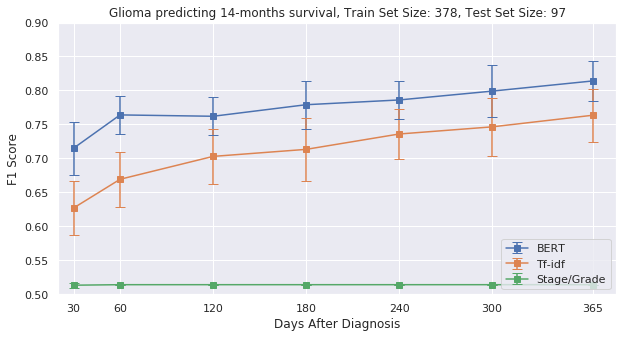

In [38]:
# Plots of time series experiments

for name in list_of_pickle_names:
    with open(PATH+name[0]+SUFFIX+'.pickle', 'rb') as f:
        results_list = pickle.load(f)
        plot_test(results_list, name[0][:1], name[1])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tfidf AUC mean =  [0.6296761  0.67305877 0.7015015  0.71200129 0.73571429 0.745281
 0.76374946]
tfidf AUC std =  [0.03994419 0.03860904 0.03959308 0.04536193 0.03744946 0.04185483
 0.0395025 ]
ClinicalBERT AUC mean =  [0.619 0.68  0.699 0.726 0.749 0.801 0.834]
ClinicalBERT AUC std =  [0.048 0.042 0.04  0.04  0.042 0.047 0.039]
diff in ratio =  [-0.01695491  0.01031296 -0.00356592  0.01966108  0.01805825  0.07476241
  0.09198113]
differences in std =  [-0.00805581 -0.00339096 -0.00040692  0.00536193 -0.00455054 -0.00514517
  0.0005025 ]


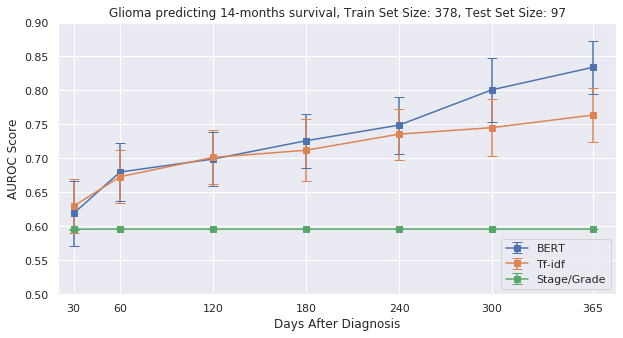

In [39]:
# Plots of time series experiments

for name in list_of_pickle_names:
    with open(PATH+name[0]+SUFFIX+'.pickle', 'rb') as f:
        results_list = pickle.load(f)
        plot_test_auc(results_list, name[0][:1], name[1])

# Plot survival ratio at each timepoint

In [37]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/share/anaconda3/envs/patient_survival/lib/python3.7/site-packages (0.12.1)


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from pytorch_pretrained_bert.tokenization import BertTokenizer
import seaborn as sns
pd.set_option('display.max_rows', 500)

In [39]:
df = pd.DataFrame({'days': [30, 60, 120, 180, 240, 300, 365, '14-months']})
df['survival'] = ""
df['non-survival'] = ""

In [40]:
train_path_30 = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_30_1.pkl"
train_data_30 = pd.read_pickle(train_path_30)
test_path_30 = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_30_1.pkl"
test_data_30 = pd.read_pickle(test_path_30)
all_data_30 = pd.concat([train_data_30, test_data_30])
df['survival'][0] = all_data_30['overallsurvival'].ge(30/365).sum()
df['non-survival'][0] = 475 - df['survival'][0]

In [41]:
train_path_60 = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_60_1.pkl"
train_data_60 = pd.read_pickle(train_path_60)
test_path_60 = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_60_1.pkl"
test_data_60 = pd.read_pickle(test_path_60)
all_data_60 = pd.concat([train_data_60, test_data_60])
df['survival'][1] = all_data_60['overallsurvival'].ge(60/365).sum()
df['non-survival'][1] = 475 - df['survival'][1]

In [42]:
train_path_120 = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_120_1.pkl"
train_data_120 = pd.read_pickle(train_path_120)
test_path_120 = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_120_1.pkl"
test_data_120 = pd.read_pickle(test_path_120)
all_data_120 = pd.concat([train_data_120, test_data_120])
df['survival'][2] = all_data_120['overallsurvival'].ge(120/365).sum()
df['non-survival'][2] = 475 - df['survival'][2]

In [43]:
train_path_180 = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_180_1.pkl"
train_data_180 = pd.read_pickle(train_path_180)
test_path_180 = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_180_1.pkl"
test_data_180 = pd.read_pickle(test_path_180)
all_data_180 = pd.concat([train_data_180, test_data_180])
df['survival'][3] = all_data_180['overallsurvival'].ge(180/365).sum()
df['non-survival'][3] = 475 - df['survival'][3]

In [44]:
train_path_240 = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_240_1.pkl"
train_data_240 = pd.read_pickle(train_path_240)
test_path_240 = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_240_1.pkl"
test_data_240 = pd.read_pickle(test_path_240)
all_data_240 = pd.concat([train_data_240, test_data_240])
df['survival'][4] = all_data_240['overallsurvival'].ge(240/365).sum()
df['non-survival'][4] = 475 - df['survival'][4]

In [45]:
train_path_300 = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_300_1.pkl"
train_data_300 = pd.read_pickle(train_path_300)
test_path_300 = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_300_1.pkl"
test_data_300 = pd.read_pickle(test_path_300)
all_data_300 = pd.concat([train_data_300, test_data_300])
df['survival'][5] = all_data_300['overallsurvival'].ge(300/365).sum()
df['non-survival'][5] = 475 - df['survival'][5]

In [46]:
train_path_365 = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_365_1.pkl"
train_data_365 = pd.read_pickle(train_path_365)
test_path_365 = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_365_1.pkl"
test_data_365 = pd.read_pickle(test_path_365)
all_data_365 = pd.concat([train_data_365, test_data_365])
df['survival'][6] = all_data_300['overallsurvival'].ge(365/365).sum()
df['non-survival'][6] = 475 - df['survival'][6]

In [47]:
train_path_14mo = "/data/users/linh/USF_Practicum/glioma_others/glioma_train_365_1.pkl"
train_data_14mo = pd.read_pickle(train_path_14mo)
test_path_14mo = "/data/users/linh/USF_Practicum/glioma_others/glioma_test_365_1.pkl"
test_data_14mo = pd.read_pickle(test_path_14mo)
all_data_14mo = pd.concat([train_data_14mo, test_data_14mo])
df['survival'][7] = all_data_300['label'].ge(1).sum()
df['non-survival'][7] = 475 - df['survival'][7]

In [48]:
df

,days,survival,non-survival
0,30,473,2
1,60,466,9
2,120,445,30
3,180,413,62
4,240,385,90
5,300,355,120
6,365,328,147
7,14-months,292,183


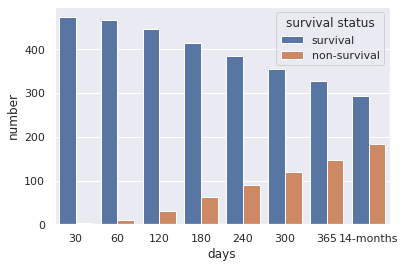

In [49]:
sns.barplot(data=df.melt(id_vars='days',
                                  value_name='number', var_name='survival status'),
            x='days', y='number', hue='survival status')

In [50]:
def plot_surv_ratio(results, disease, period_of_analysis_days=None):
    """This funtion plot the experiment results."""
    disease_name = ''
    if disease[0] == 'g':
        disease_name = 'Glioma'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'p':
        disease_name = 'Prostate'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'l':
        disease_name = 'Lung'
        label_stage = 'Stage/Grade'
    elif disease[0] == 'b':
        disease_name = 'Breast'
        label_stage = 'Stage/Grade'

    sns.set(style="darkgrid")
    mean_f1_list = []
    mean_f1_s_list = []

    for result_i in results:
        mean_f1_list.append(list(map(lambda x: x[0], result_i['f1'])))
        mean_f1_s_list.append(list(map(lambda x: x[0], result_i['f1_s'])))

    mean_f1 = np.array(mean_f1_list).mean(axis=0)
    mean_f1_bert = f1_bert_results.iloc[:,1].values
    
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10, 5))
    min_xlim = min(20,period_of_analysis_days[0]-10)
    plt.xlim((min_xlim, 380))
    plt.ylim((0.5, 0.9))
    plt.xlabel("Days After Diagnosis")
    plt.ylabel("F1 Score")
    plt.title(
        f"{disease_name} predicting 14-months survival, Train Set Size: {results[0]['n'][-1]}, Test Set Size: {results[0]['n_test'][-1]}")

    xticks_list = sorted(list(set([period_of_analysis_days[0]]+[60, 120, 180, 240, 300, 365])))
    plt.xticks(xticks_list)

    plt.errorbar(period_of_analysis_days, mean_f1_bert, yerr=std_f1_bert, label='BERT', marker='s', capsize=5)
    plt.errorbar(period_of_analysis_days, mean_f1, yerr=std_f1, label='Tf-idf', marker='s', capsize=5)
    plt.errorbar(period_of_analysis_days, mean_f1_s,
                 yerr=std_f1_s, label=label_stage, marker='s', capsize=5)
    plt.legend(loc='lower right')
    os.makedirs('EPS_experiment', 0o777, True)    
    plt.savefig(
        f'EPS_experiment/{disease}{str(period_of_analysis_days[0])}.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)


# Make series plot of each experimental set (21 in total)

In [96]:
f1_path = '/home/linh/nlp/ClinicalBERT_Notebook/BERToutputs/'
f1_bert = {}
concat_f1 = []
days = ['30', '60', '120', '180', '240', '300', '365']
for day in days:
    f1_bert[day] = pd.read_csv(f1_path+'f1_'+day+'.csv', header = None)
    concat_f1.append(f1_bert[day])

f1_df = pd.concat(concat_f1, axis=1, ignore_index=False)
f1_df.columns = days

f1_df

,30,60,120,180,240,300,365
0,0.7482,0.7857,0.7556,0.8085,0.7770,0.7970,0.8235
1,0.7770,0.7681,0.7328,0.7463,0.7704,0.7794,0.8088
2,0.7407,0.7941,0.8085,0.7647,0.8175,0.8209,0.8372
3,0.7481,0.8029,0.7910,0.7612,0.8060,0.8217,0.7939
4,0.7368,0.7737,0.8000,0.8235,0.8148,0.8527,0.8504
5,0.7647,0.7852,0.7612,0.7820,0.7879,0.8281,0.8438
6,0.6614,0.7231,0.7077,0.7852,0.8031,0.8209,0.8462
7,0.6963,0.7368,0.7368,0.7606,0.7556,0.8060,0.8060
8,0.7164,0.7737,0.7391,0.7519,0.7669,0.7812,0.7846
9,0.7463,0.7556,0.7794,0.8296,0.8088,0.8182,0.8175


In [146]:
auc_path = '/home/linh/nlp/ClinicalBERT_Notebook/BERToutputs/'
auc_bert = {}
concat_auc = []
days = ['30', '60', '120', '180', '240', '300', '365']
for day in days:
    auc_bert[day] = pd.read_csv(auc_path+'roc_'+day+'.csv', header = None)
    concat_auc.append(auc_bert[day])

auc_df = pd.concat(concat_auc, axis=1, ignore_index=False)
auc_df.columns = days

auc_df

,30,60,120,180,240,300,365
0,0.6167,0.6419,0.7541,0.7644,0.7716,0.7982,0.8342
1,0.6311,0.6559,0.6459,0.6775,0.7342,0.7937,0.8360
2,0.7005,0.7450,0.7486,0.7455,0.7937,0.8725,0.8824
3,0.6671,0.7171,0.7014,0.7315,0.7459,0.8068,0.8113
4,0.6572,0.7059,0.7221,0.7671,0.7955,0.8788,0.9153
5,0.6527,0.7536,0.6824,0.7374,0.7387,0.8095,0.8635
6,0.6041,0.6428,0.6477,0.6914,0.7365,0.8068,0.8225
7,0.6221,0.6707,0.6577,0.6847,0.7027,0.7721,0.8297
8,0.6126,0.6716,0.6640,0.6779,0.7374,0.7820,0.8167
9,0.6667,0.7113,0.7306,0.7320,0.7532,0.8036,0.8432


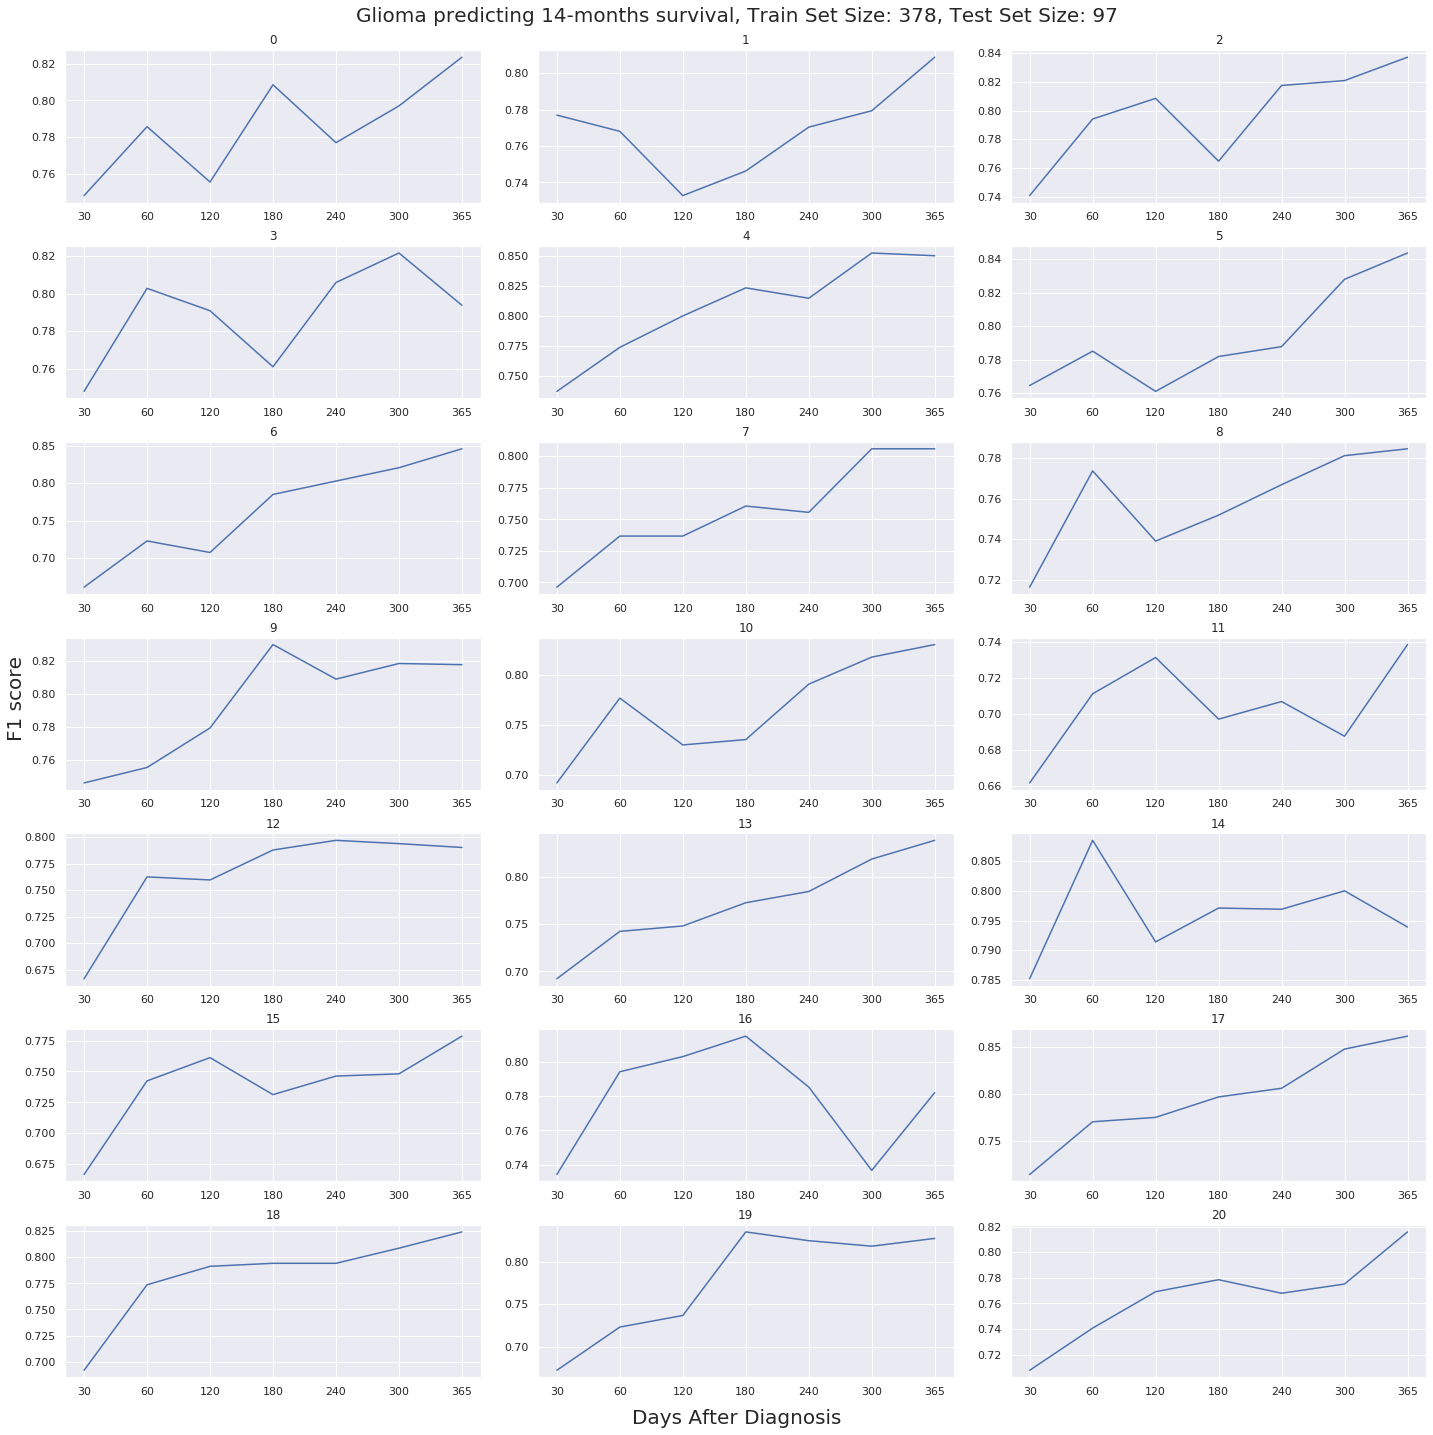

In [144]:
fig, ax = plt.subplots(7, 3, figsize=(20, 20))  # example
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, (name, row) in enumerate(f1_df.iterrows()):
    ax = plt.subplot(7,3, i+1)
    ax.set_title(row.name)
    ax.plot(row)
    
fig.suptitle('Glioma predicting 14-months survival, Train Set Size: 378, Test Set Size: 97', fontsize=20)
fig.text(0.5,0., "Days After Diagnosis", ha="center", va="center")
fig.text(0.,0.5, "F1 score", ha="center", va="center", rotation=90)

plt.savefig(
        f'EPS_experiment/glioma30_21sets_f1.eps', format='eps', bbox_inches = 'tight', pad_inches = 0)
plt.show()

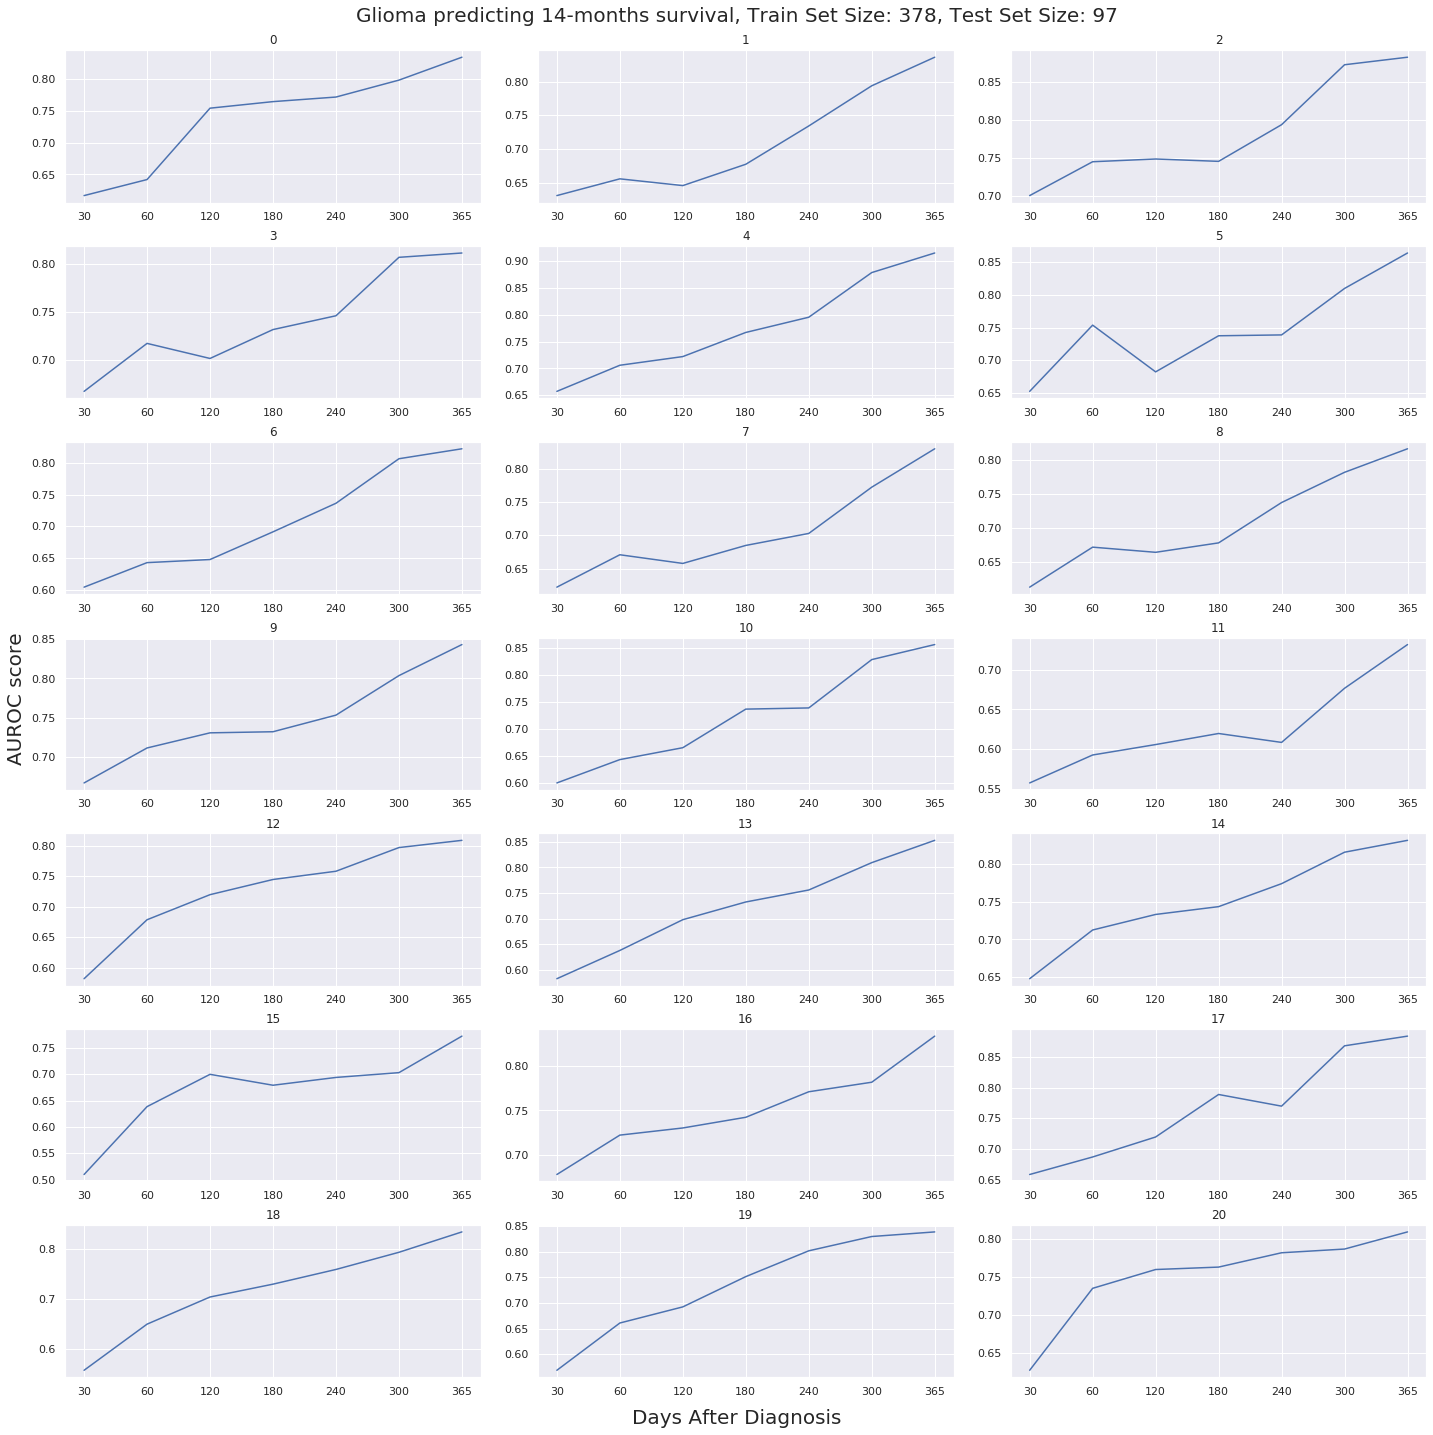

In [147]:
fig, ax = plt.subplots(7, 3, figsize=(20, 20))  # example
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, (name, row) in enumerate(auc_df.iterrows()):
    ax = plt.subplot(7,3, i+1)
    ax.set_title(row.name)
    ax.plot(row)
    
fig.suptitle('Glioma predicting 14-months survival, Train Set Size: 378, Test Set Size: 97', fontsize=20)
fig.text(0.5,0., "Days After Diagnosis", ha="center", va="center")
fig.text(0.,0.5, "AUROC score", ha="center", va="center", rotation=90)

plt.savefig(
        f'EPS_experiment/glioma30_21sets_auc.eps', format='eps', bbox_inches = 'tight', pad_inches = 0)
plt.show()